# Preprocessing the data

Data is generally:
- **Incomplete**: lacking attribute values, lacking certain attributes of interest, or containing only aggregate data
- **Noisy**: containing errors or outliers
- **Inconsistent**: containing discrepancies in codes or names
    
Data cleaning consists of filling in missing values, smoothing noisy data, identifying or removing outliers, and resolving inconsistencies.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Reading the data

In [4]:
names=['age', 'sex', 'chest_pain', 'rest_blood_pressure', 'cholestorol', 'fast_blood_sugar', 'rest_ecg', 'max_heart_rate', 'exercise_angina', 'st_depression', 'st_slope', 'major_vessels', 'thal', 'target']
files = ['cleveland.csv', 'hungary.csv', 'switzerland.csv', 'va.csv']

# Read in the files as a single dataframe
dfs = (pd.read_csv(f, names=names, na_values=['?', -9]) for f in files)
df = pd.concat(dfs, ignore_index=True)

# Display the first 10 records
df.head(5)

,age,sex,chest_pain,rest_blood_pressure,cholestorol,fast_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,st_slope,major_vessels,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


### Fix data types

In [5]:
# Convert categorical variables
df[['sex', 'chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal', 'target']] = df[['sex', 'chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal', 'target']].astype('category')

In [6]:
df.dtypes

age                     float64
sex                    category
chest_pain             category
rest_blood_pressure     float64
cholestorol             float64
fast_blood_sugar       category
rest_ecg               category
max_heart_rate          float64
exercise_angina        category
st_depression           float64
st_slope               category
major_vessels          category
thal                   category
target                 category
dtype: object

## Replacing missing values


In [7]:
print("Shape of the dataset:", df.shape)
df.isnull().sum()

Shape of the dataset: (921, 14)


age                      1
sex                      1
chest_pain               1
rest_blood_pressure     60
cholestorol             31
fast_blood_sugar        91
rest_ecg                 3
max_heart_rate          56
exercise_angina         56
st_depression           63
st_slope               310
major_vessels          611
thal                   487
target                   1
dtype: int64

### Observations
- Age and sex have very few missing records. These will be replaced with the mean of the dataset and the mode (the most frequent) respectively
- One record does not contain a `target` outcome (healthy or not healthy), so this can be removed
- `major_vessels` has the most amount of missing values, next to `thal`. These missing values are about a 2/3 of the length of the dataset, so the column should probably be dropped. For now however the values will be imputed.
- For other variables, it makes sense to fill the missing values with means and modes from a subset of similar patients. For example, an older patient is more likely to have a similar heart rate to another patient of similar age and gender, so it might not make sense to replace this value with the average of all of the patient's heart rates. 

Replacing the age and sex will be done using sklearn's `Imputer`:

In [8]:
from sklearn.preprocessing.imputation import Imputer 

mean_imputer = Imputer(missing_values='NaN', strategy='mean')
mode_imputer = Imputer(missing_values='NaN', strategy='most_frequent')

# Replace missing values in age with the mean
df['age'] = mean_imputer.fit_transform(df[['age']]) 

# Replace missing values in sex with the mode
df['sex'] = mode_imputer.fit_transform(df[['sex']]) 

For the other columns, replacing will be done by using the mean or mode of a subset of the data. 
Specific functions are defined for this purpose:

In [9]:
def impute_mean(attr):
    """
    Fill NaNs for numerical attributes with 
    the attribute mean of a subset of patients
    with similar age and sex. 
    """
    indices = df[df.loc[:, attr].isnull() == True].index

    for i in indices:
        # get age and sex for corresponding record
        age = df['age'].iloc[i]
        sex = df['sex'].iloc[i]

        # get a subset of patients within a similar range and sex
        subset = df[df['age'].between(age - 5, age + 5) & df['sex'] == sex]
        mean = subset[attr].mean() 
        
        # fill the record using the mean of attribute from the subset
        df[attr].fillna(mean, inplace=True)
        #df[attr] = mean_imputer.fit_transform(df[[attr]]) 
        
def impute_mode(attr):
    """
    Fill NaNs for categorical attributes with 
    the attribute mode of a subset of patients
    with similar age and sex. 
    """
    indices = df[df.loc[:, attr].isnull() == True].index

    for i in indices:
        # get age and sex for corresponding record
        age = df['age'].iloc[i]
        sex = df['sex'].iloc[i]

        # get a subset of patients within a similar range and sex
        subset = df[df['age'].between(age - 5, age + 5) & df['sex'] == sex]
        mode = subset[attr].mode()[0]
        
        # fill the record using the mean of attribute from the subset
        df[attr].fillna(mode, inplace=True)

In [10]:
# Fill missing values in numerical columns
nums = ['rest_blood_pressure', 'cholestorol', 'max_heart_rate', 'st_depression']
for i in nums:
    impute_mean(i)
    print("NaNs for", i, df[i].isnull().sum())
    
# Fill missing values in categorical columns
cats = ['chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal']
for i in cats:
    impute_mode(i)
    print("NaNs for", i, df[i].isnull().sum())
    
# Drop the record with a missing target
df.dropna(inplace=True)

NaNs for rest_blood_pressure 0
NaNs for cholestorol 0
NaNs for max_heart_rate 0
NaNs for st_depression 0
NaNs for chest_pain 0
NaNs for fast_blood_sugar 0
NaNs for rest_ecg 0
NaNs for exercise_angina 0
NaNs for st_slope 0
NaNs for major_vessels 0
NaNs for thal 0


All of the missing values have now been replaced:

In [11]:
df.isnull().sum()

age                    0
sex                    0
chest_pain             0
rest_blood_pressure    0
cholestorol            0
fast_blood_sugar       0
rest_ecg               0
max_heart_rate         0
exercise_angina        0
st_depression          0
st_slope               0
major_vessels          0
thal                   0
target                 0
dtype: int64

In [12]:
# Convert categorical variables
df[['sex', 'chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal', 'target']] = df[['sex', 'chest_pain', 'fast_blood_sugar', 'rest_ecg', 'exercise_angina', 'st_slope', 'major_vessels', 'thal', 'target']].astype('category')

## Categorical variables

In [13]:
print("Categories\n")
for i in (cats + ['target']):
    print(i, "\n", df[i].cat.categories.tolist())

Categories

chest_pain 
 [1.0, 2.0, 3.0, 4.0]
fast_blood_sugar 
 [0.0, 1.0]
rest_ecg 
 [0.0, 1.0, 2.0]
exercise_angina 
 [0.0, 1.0]
st_slope 
 [1.0, 2.0, 3.0]
major_vessels 
 [0.0, 1.0, 2.0, 3.0, 9.0]
thal 
 [3.0, 6.0, 7.0]
target 
 [0.0, 1.0, 2.0, 3.0, 4.0]


### Observations
- `target` is the outcome variable which dictates whether or not a patient is healthy (0), or have some form of cardiovascular disease (4 types in total: 1, 2, 3, 4). For the purpose of predicting whether or not a patient is at risk, only two should suffice (0 = healthy, 1 = at risk).
- Some categories contain -9, which is the equivalent to a missing value. These were converted to NaNs when the data was read in

In [33]:
# Replace the categories 1, 2, 3, 4 with just 1
df['target'] = df['target'].replace({0.0: 0, 1.0: 1, 2.0: 1, 3.0: 1, 4.0: 1}).astype('category')
df['target'].unique()

[0, 1]
Categories (2, int64): [0, 1]

# Exploring the data

In [34]:
df.describe()

,age,rest_blood_pressure,cholestorol,max_heart_rate,st_depression
count,920.000000,920.000000,920.000000,920.000000,920.000000
mean,53.510870,132.178155,198.702917,137.510776,0.883664
std,9.424685,18.444724,108.982529,25.138876,1.053930
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,177.750000,120.000000,0.000000
50%,54.000000,130.000000,221.000000,138.000000,0.800000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [35]:
# 1 indicates the presence of heart disease
# 0 indicates that the patient is healthy
print(df['target'].value_counts(), "\n")

# 1 is male
# 2 is female 
print(df['sex'].value_counts(), "\n")

# number of healthy/sick patients per gender
print(pd.crosstab(df['target'], df['sex']))

1    509
0    411
Name: target, dtype: int64 

1.0    726
0.0    194
Name: sex, dtype: int64 

sex     0.0  1.0
target          
0       144  267
1        50  459


[Text(0.5,0,'ST depression')]

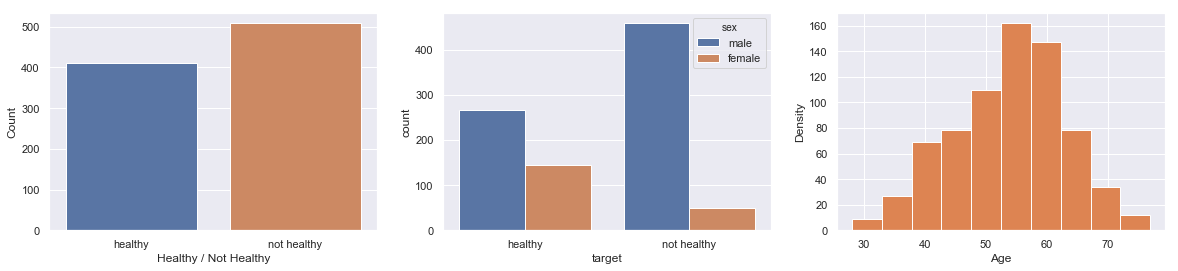

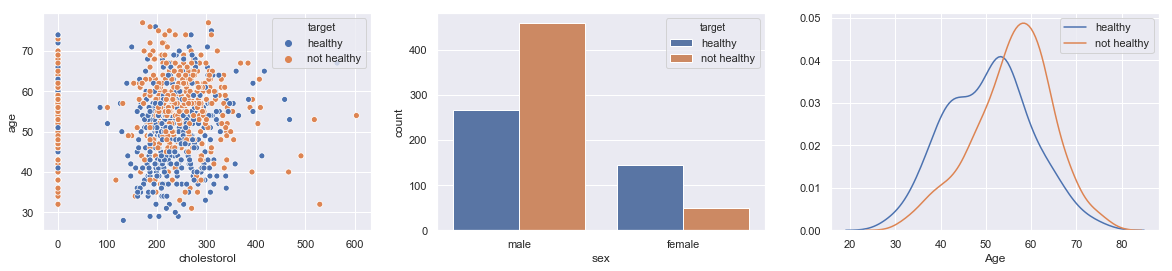

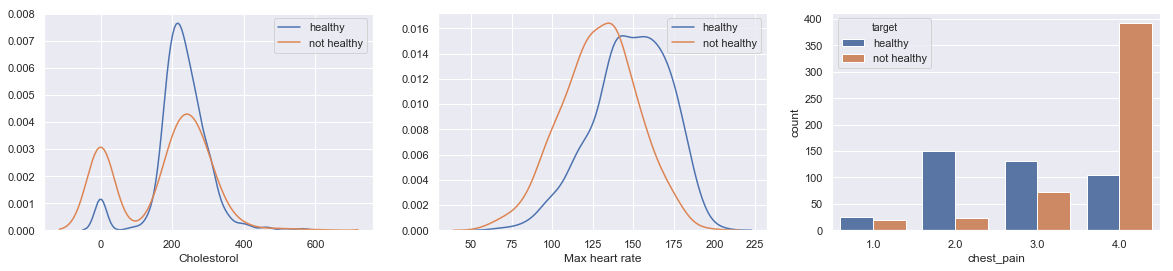

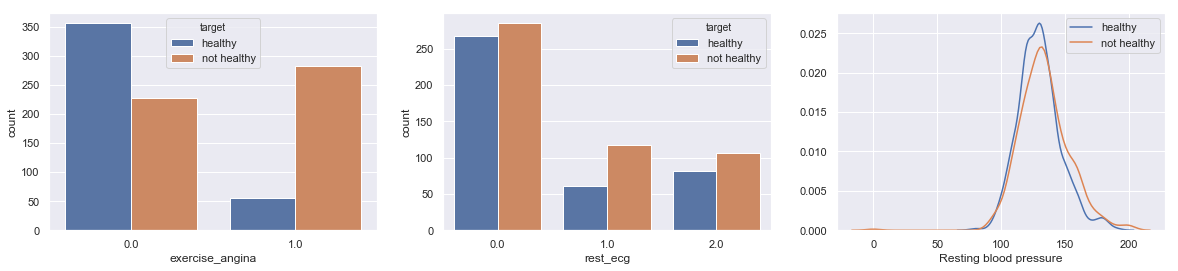

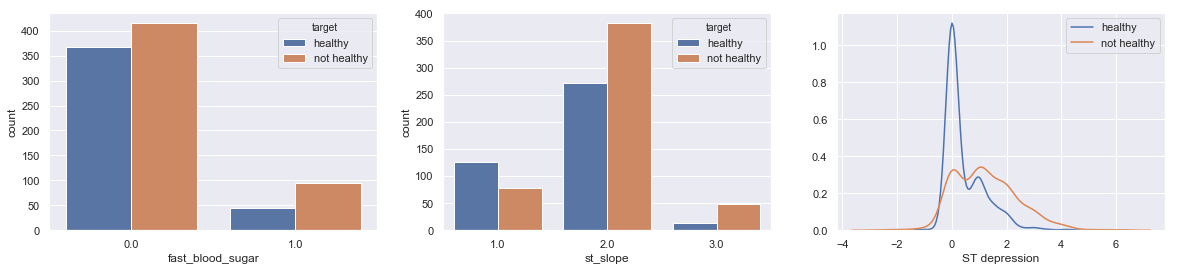

In [177]:
sns.set(palette="deep")

# Make a copy of the data to relabel the categories
data = df.copy()
data['sex'] = data['sex'].replace({0: 'female', 1: 'male'})
data['target'] = data['target'].replace({0: 'healthy', 1: 'not healthy'})

# -------------------------------------------------
# Row 1
# -------------------------------------------------
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

# 0: Plot amount of healthy / sick patients
sns.countplot(x='target', data=data, ax=ax[0])
ax[0].set(xlabel='Healthy / Not Healthy', ylabel='Count')

# 1: Plot heart disease probability for gender
sns.countplot(x='target', hue="sex", data=data, ax=ax[1])

# 2: Plot age histogram
df.groupby('sex').age.hist()
ax[2].set(xlabel='Age', ylabel='Density')


# -------------------------------------------------
# Row 2
# -------------------------------------------------
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

# Plot cholestorol distribution
# sns.distplot(df['cholestorol'], ax=ax[0])
sns.scatterplot(x="cholestorol", y="age", hue="target", data=data, ax=ax[0])

# Plot sex by healthy vs not healthy
sns.countplot(x='sex', hue="target", data=data, ax=ax[1])

# Plot age by healthy vs not healthy
sns.kdeplot(data.age[data.target == "healthy"], label='healthy', ax=ax[2])
sns.kdeplot(data.age[data.target == "not healthy"], label='not healthy', ax=ax[2])
ax[2].set(xlabel='Age')

# sns.barplot(x='sex', y='target', data=df)
# ax[1].set(xlabel='Sex', ylabel='Heart Disease')

# -------------------------------------------------
# Row 3
# -------------------------------------------------
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

# Plot cholestorol by healthy vs not healthy
sns.kdeplot(data.cholestorol[data.target == "healthy"], label='healthy', ax=ax[0])
sns.kdeplot(data.cholestorol[data.target == "not healthy"], label='not healthy', ax=ax[0])
ax[0].set(xlabel='Cholestorol')

# Plot heart rate by healthy vs not healthy
sns.kdeplot(data.max_heart_rate[data.target == "healthy"], label='healthy', ax=ax[1])
sns.kdeplot(data.max_heart_rate[data.target == "not healthy"], label='not healthy', ax=ax[1])
ax[1].set(xlabel='Max heart rate')

# Plot chest pain by healthy vs not healthy
sns.countplot(x='chest_pain', hue="target", data=data, ax=ax[2])

# -------------------------------------------------
# Row 4
# -------------------------------------------------
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

# Plot exercise chest pain by healthy vs not healthy
sns.countplot(x='exercise_angina', hue="target", data=data, ax=ax[0])

# Plot rest ecg by healthy vs not healthy
sns.countplot(x='rest_ecg', hue="target", data=data, ax=ax[1])

# Plot blood pressure by healthy vs not healthy
sns.kdeplot(data.rest_blood_pressure[data.target == "healthy"], label='healthy', ax=ax[2])
sns.kdeplot(data.rest_blood_pressure[data.target == "not healthy"], label='not healthy', ax=ax[2])
ax[2].set(xlabel='Resting blood pressure')

# -------------------------------------------------
# Row 4
# -------------------------------------------------
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))

# Plot fasting blood sugar by healthy vs not healthy
sns.countplot(x='fast_blood_sugar', hue="target", data=data, ax=ax[0])

# Plot st slope by healthy vs not healthy
sns.countplot(x='st_slope', hue="target", data=data, ax=ax[1])

# Plot st depression by healthy vs not healthy
sns.kdeplot(data.st_depression[data.target == "healthy"], label='healthy', ax=ax[2])
sns.kdeplot(data.st_depression[data.target == "not healthy"], label='not healthy', ax=ax[2])
ax[2].set(xlabel='ST depression')

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


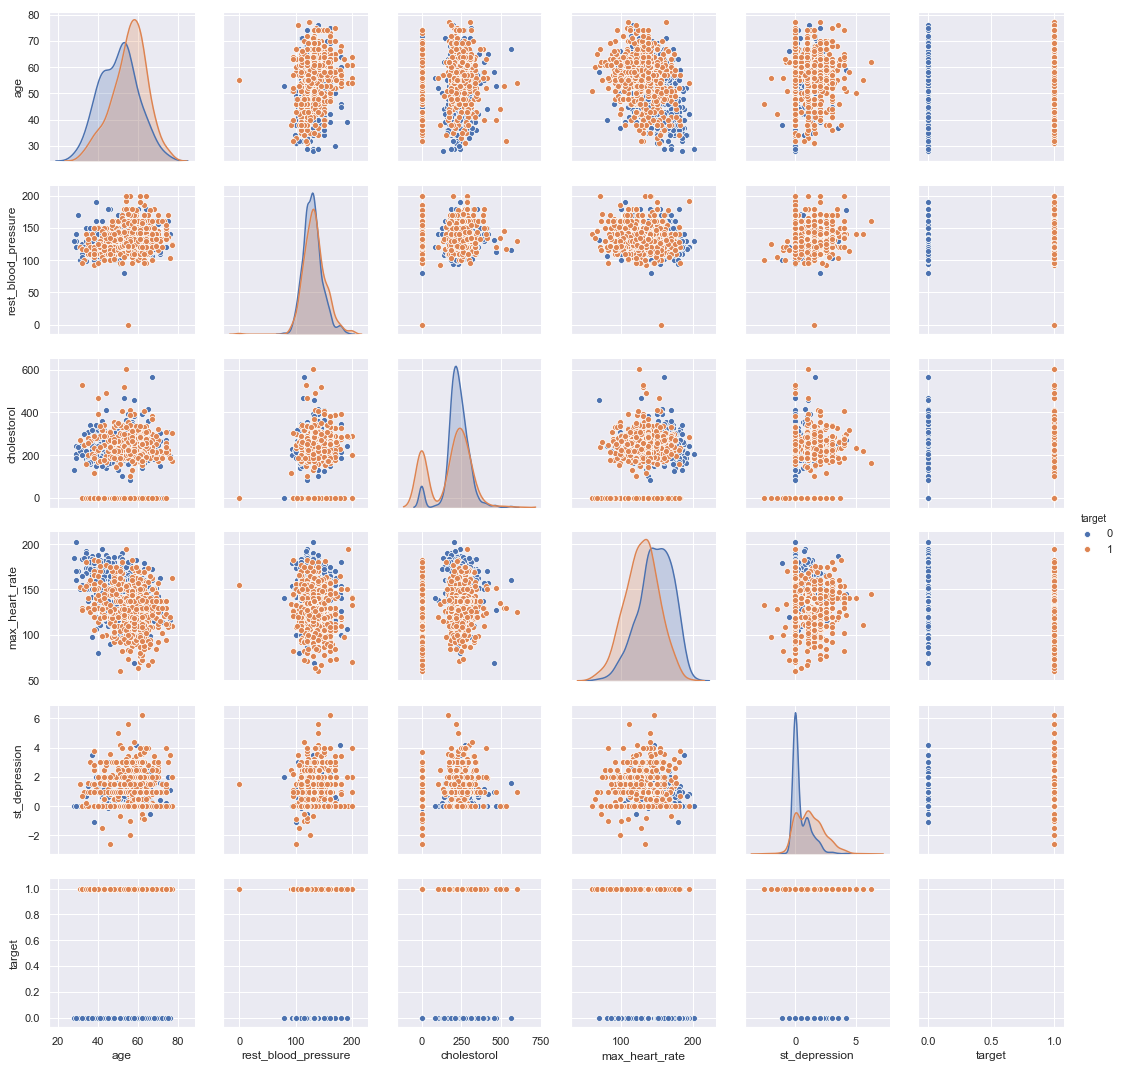

In [173]:
nums = df[['age', 'rest_blood_pressure', 'cholestorol', 'max_heart_rate', 'st_depression', 'target']]
sns.pairplot(nums, hue = 'target')